In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [2]:
# Data directory
data_dir = 'coal_defect_classification'

# Check if the directory exists and has the required subdirectories
if not os.path.exists(data_dir):
    print(f"Error: Directory '{data_dir}' not found!")
else:
    print("Found coal_defect_classification directory")
    subdirs = os.listdir(data_dir)
    print(f"Subdirectories: {subdirs}")


Found coal_defect_classification directory
Subdirectories: ['Cracks_and_fractures', 'Surface_deformation']


In [3]:
# Data augmentation and normalization for training
# More aggressive transforms since we have limited data
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.8, 1.2)),
        transforms.RandomGrayscale(p=0.1),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [4]:

def create_train_val_split(data_dir, val_ratio=0.2):
    """
    Create train and validation splits from the data directory
    """
    import shutil
    import random
    
    # Create train and val directories
    train_dir = os.path.join(data_dir, 'train')
    val_dir = os.path.join(data_dir, 'val')
    
    # Remove existing splits if they exist
    for dir_path in [train_dir, val_dir]:
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
        os.makedirs(dir_path)
    
    # Get class names from subdirectories
    class_names = [d for d in os.listdir(data_dir) 
                  if os.path.isdir(os.path.join(data_dir, d)) and d not in ['train', 'val']]
    
    print(f"Found classes: {class_names}")
    
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
            
        # Create class directories in train and val
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        
        # Get all images
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(images)
        
        # Split images
        val_count = int(len(images) * val_ratio)
        train_images = images[val_count:]
        val_images = images[:val_count]
        
        print(f"Class {class_name}: {len(train_images)} training, {len(val_images)} validation images")
        
        # Copy images to respective directories
        for img in train_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(train_dir, class_name, img)
            shutil.copy2(src, dst)
            
        for img in val_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(val_dir, class_name, img)
            shutil.copy2(src, dst)
    
    return train_dir, val_dir, class_names

# Create train/val split
train_dir, val_dir, class_names = create_train_val_split(data_dir, val_ratio=0.2)

print(f"Class names: {class_names}")

# Create datasets
image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, data_transforms['val'])
}

# Create data loaders
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=16, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=16, shuffle=False, num_workers=4)
}


Found classes: ['Cracks_and_fractures', 'Surface_deformation']
Class Cracks_and_fractures: 76 training, 19 validation images
Class Surface_deformation: 79 training, 19 validation images
Class names: ['Cracks_and_fractures', 'Surface_deformation']


In [5]:
# Dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f"Final class names: {class_names}")
print(f"Training samples: {dataset_sizes['train']}")
print(f"Validation samples: {dataset_sizes['val']}")


Final class names: ['Cracks_and_fractures', 'Surface_deformation']
Training samples: 155
Validation samples: 38


Sample augmented training images:


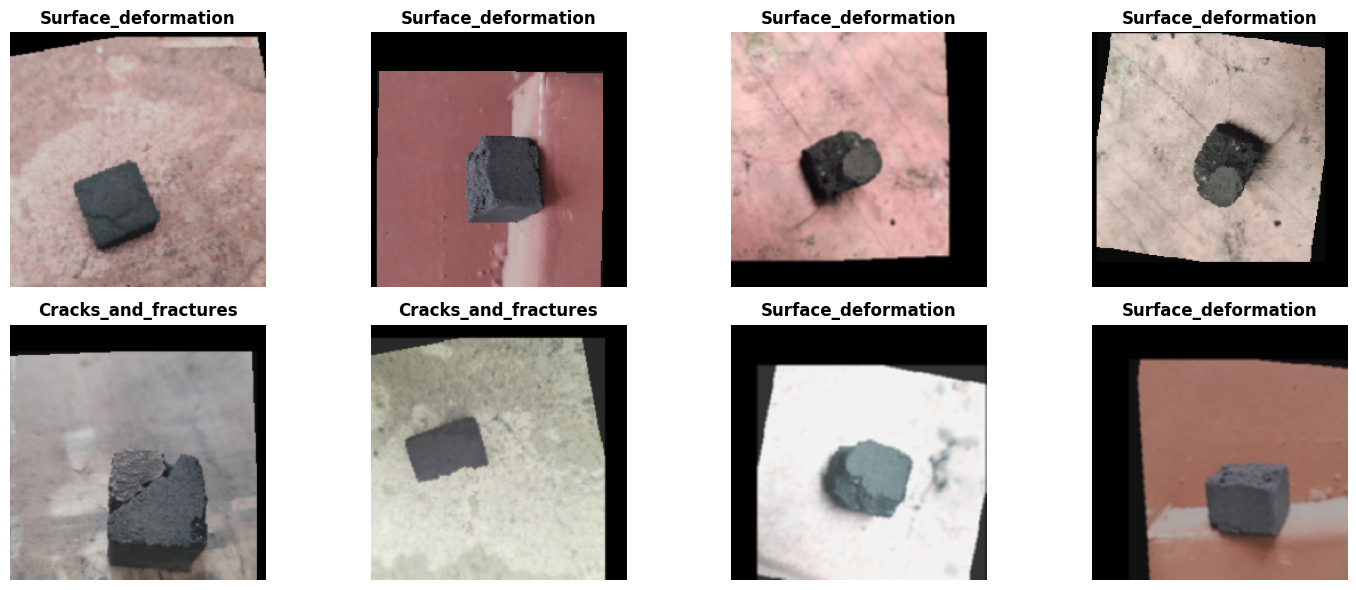

In [6]:
# Function to display sample images
def show_augmented_images(dataloader, class_names, num_images=8):
    """Display sample augmented images"""
    inputs, classes = next(iter(dataloader))
    
    # Calculate grid dimensions
    cols = 4
    rows = (num_images + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    axes = axes.flatten()
    
    for idx in range(min(num_images, len(inputs))):
        img = inputs[idx]
        label = classes[idx]
        
        # Convert tensor to numpy and denormalize
        img = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        # Display image
        axes[idx].imshow(img)
        axes[idx].set_title(f'{class_names[label]}', fontsize=12, fontweight='bold')
        axes[idx].axis('off')
    
    # Hide any unused subplots
    for idx in range(min(num_images, len(inputs)), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display sample augmented images
print("Sample augmented training images:")
show_augmented_images(dataloaders['train'], class_names, num_images=8)


In [7]:

# Load pre-trained model with more layers unfrozen for fine-tuning
def create_model(num_classes):
    """Create and configure the model for defect classification"""
    # Use ResNet50 pre-trained on ImageNet
    model = models.resnet50(pretrained=True)
    
    # Freeze early layers, fine-tune later layers
    # We'll unfreeze the last two bottleneck blocks
    for name, param in model.named_parameters():
        if 'layer3' in name or 'layer4' in name or 'fc' in name:
            param.requires_grad = True
        else:
            param.requires_grad = False
    
    # Replace the final fully connected layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, 512),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(512),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(256, num_classes)
    )
    
    return model


In [8]:

# Create model
model = create_model(len(class_names))
model = model.to(device)

# Print model summary
print("Model architecture:")
print(model)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params:,}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable ratio: {trainable_params/total_params:.2%}")

# Define loss function with class weights (useful for imbalanced data)
def get_class_weights(dataloader, num_classes):
    """Calculate class weights for imbalanced datasets"""
    class_counts = torch.zeros(num_classes)
    for _, labels in dataloader:
        for label in labels:
            class_counts[label] += 1
    
    # Inverse frequency weighting
    class_weights = 1.0 / class_counts
    class_weights = class_weights / class_weights.sum() * num_classes
    
    return class_weights.to(device)

class_weights = get_class_weights(dataloaders['train'], len(class_names))
print(f"Class weights: {class_weights}")

criterion = nn.CrossEntropyLoss(weight=class_weights)

# Use different learning rates for different parts of the model
optimizer = optim.AdamW([
    {'params': model.layer3.parameters(), 'lr': 1e-4},
    {'params': model.layer4.parameters(), 'lr': 1e-4},
    {'params': model.fc.parameters(), 'lr': 1e-3}
])

# Learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Enhanced training function with metrics
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Track training history
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    learning_rates = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 40)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            if phase == 'train':
                scheduler.step()
                current_lr = optimizer.param_groups[0]['lr']
                learning_rates.append(current_lr)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Track history
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.cpu().numpy())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.cpu().numpy())

            # Deep copy the model if it's the best so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # Save the best model
                torch.save(model.state_dict(), 'coal_defect_classification_best.pth')

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    # Plot training history
    plt.figure(figsize=(15, 5))
    
    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Accuracy plot
    plt.subplot(1, 3, 2)
    plt.plot(train_acc_history, label='Training Accuracy')
    plt.plot(val_acc_history, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Learning rate plot
    plt.subplot(1, 3, 3)
    plt.plot(learning_rates)
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history


Model architecture:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size

Starting training for defect classification...
Epoch 1/30
----------------------------------------
train Loss: 0.6865 Acc: 0.5677
val   Loss: 0.5929 Acc: 0.6842

Epoch 2/30
----------------------------------------
train Loss: 0.5801 Acc: 0.6645
val   Loss: 0.4917 Acc: 0.7105

Epoch 3/30
----------------------------------------
train Loss: 0.3924 Acc: 0.8323
val   Loss: 0.2862 Acc: 0.8421

Epoch 4/30
----------------------------------------
train Loss: 0.2499 Acc: 0.9032
val   Loss: 0.3823 Acc: 0.7895

Epoch 5/30
----------------------------------------
train Loss: 0.1898 Acc: 0.9290
val   Loss: 0.3361 Acc: 0.8421

Epoch 6/30
----------------------------------------
train Loss: 0.1553 Acc: 0.9355
val   Loss: 0.2302 Acc: 0.8947

Epoch 7/30
----------------------------------------
train Loss: 0.2249 Acc: 0.9355
val   Loss: 0.2685 Acc: 0.8684

Epoch 8/30
----------------------------------------
train Loss: 0.1351 Acc: 0.9548
val   Loss: 0.6800 Acc: 0.7368

Epoch 9/30
----------------------

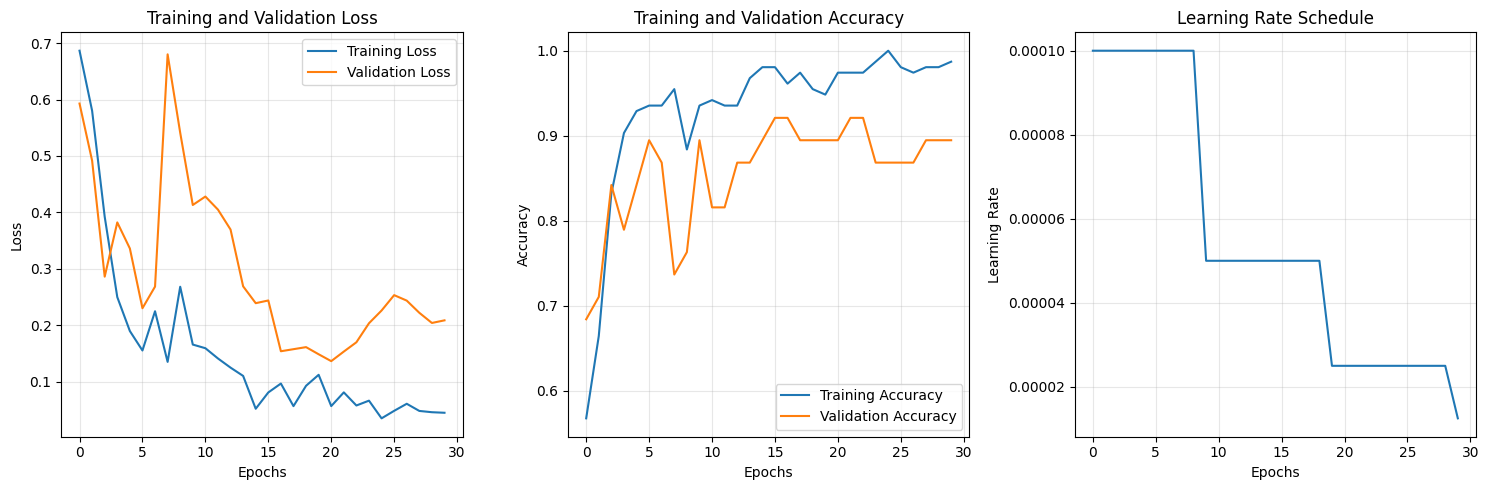

In [9]:
# Train the model
print("Starting training for defect classification...")
model, train_loss, train_acc, val_loss, val_acc = train_model(
    model, criterion, optimizer, scheduler, num_epochs=30
)


In [10]:

# Save the final model
torch.save(model.state_dict(), 'coal_defect_classification_final.pth')
print("Model saved as 'coal_defect_classification_final.pth'")


Model saved as 'coal_defect_classification_final.pth'



Testing on validation set samples:


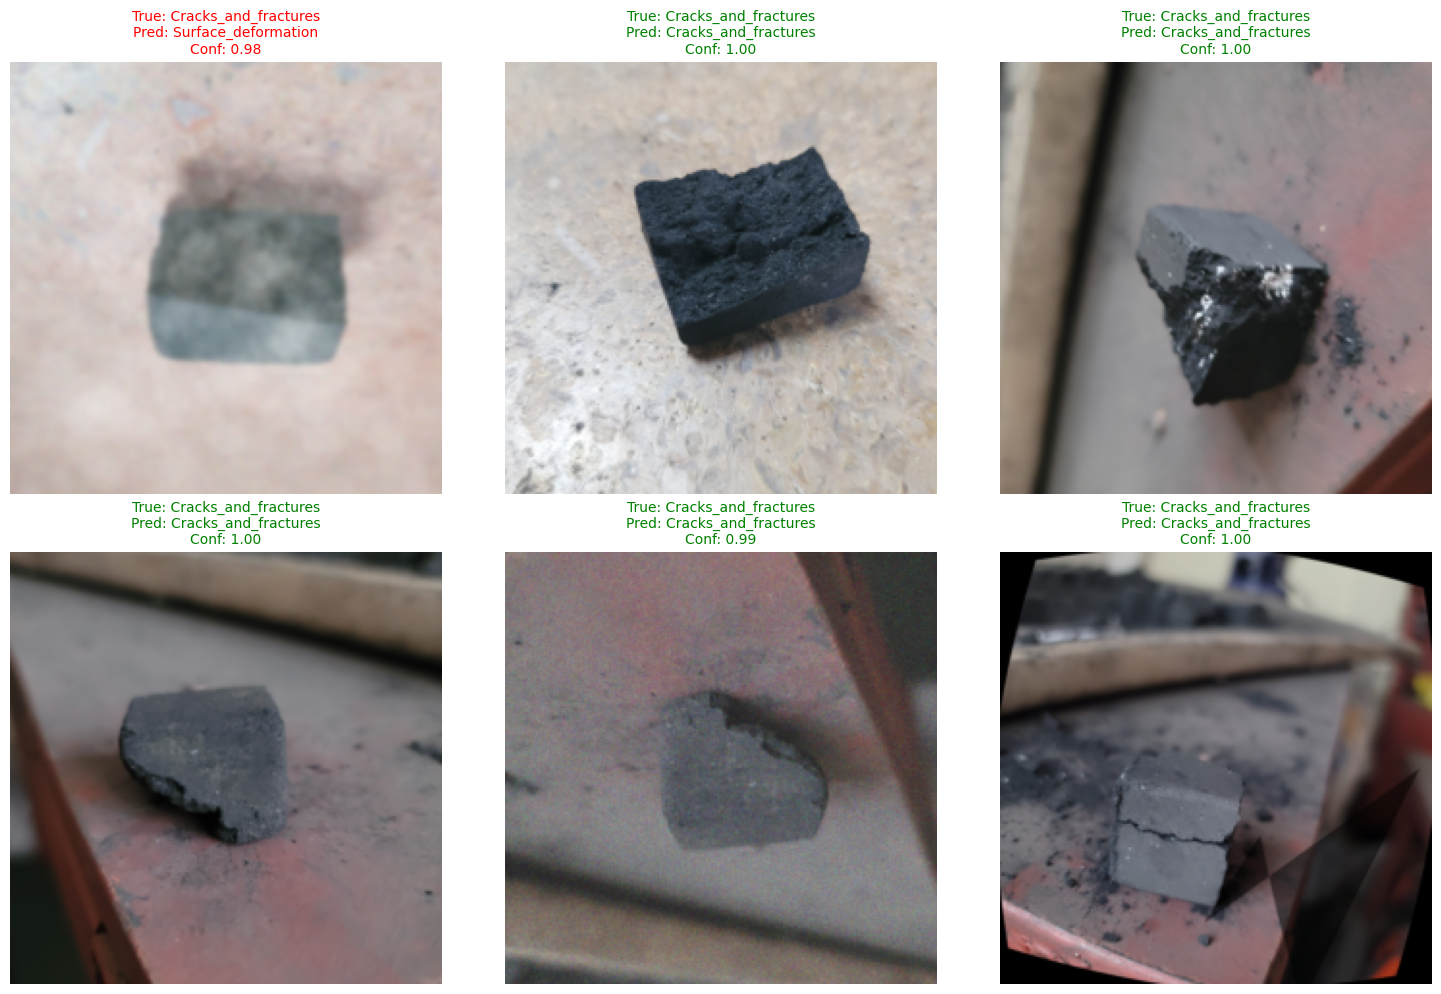

Validation sample accuracy: 83.33% (5/6)


In [12]:


# Function to test the model on a single image
def predict_defect_type(image_path, model, class_names):
    """
    Predict the type of defect in a coal cube
    
    Args:
        image_path (str): Path to the image file
        model: Trained PyTorch model
        class_names: List of class names
    
    Returns:
        dict: Prediction results
    """
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    
    # Apply validation transforms
    preprocess = data_transforms['val']
    image_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension
    
    # Move to device
    image_tensor = image_tensor.to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    # Make prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    # Get results
    predicted_class = class_names[predicted.item()]
    confidence_score = confidence.item()
    
    # Display the image and prediction
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}\nConfidence: {confidence_score:.4f}', fontsize=14)
    plt.axis('off')
    
    # Show probabilities
    plt.subplot(1, 2, 2)
    probs = probabilities.cpu().numpy()[0]
    colors = ['red' if x == predicted.item() else 'blue' for x in range(len(class_names))]
    bars = plt.bar(class_names, probs, color=colors, alpha=0.7)
    plt.title('Defect Type Probabilities', fontsize=14)
    plt.xticks(rotation=45)
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    
    # Add probability values on bars
    for bar, prob in zip(bars, probs):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{prob:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'predicted_class': predicted_class,
        'confidence': confidence_score,
        'all_probabilities': {class_names[i]: float(probs[i]) for i in range(len(class_names))}
    }

# Test the model with sample images from validation set
def test_model_on_validation_set(model, class_names, num_images=6):
    """Test the model on validation set images"""
    model.eval()
    
    # Get a batch from validation set
    inputs, labels = next(iter(dataloaders['val']))
    inputs = inputs[:num_images]
    labels = labels[:num_images]
    
    # Calculate grid dimensions
    cols = 3
    rows = (num_images + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    axes = axes.flatten()
    
    correct_predictions = 0
    
    for idx in range(min(num_images, len(inputs))):
        img = inputs[idx]
        true_label = labels[idx]
        
        # Prepare image for prediction
        img_tensor = img.unsqueeze(0).to(device)
        
        with torch.no_grad():
            outputs = model(img_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)
        
        predicted_class = class_names[predicted.item()]
        true_class = class_names[true_label.item()]
        confidence_score = confidence.item()
        
        # Convert tensor to numpy for display
        display_img = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        display_img = std * display_img + mean
        display_img = np.clip(display_img, 0, 1)
        
        # Display image
        axes[idx].imshow(display_img)
        
        # Color code based on prediction correctness
        color = 'green' if predicted_class == true_class else 'red'
        axes[idx].set_title(f'True: {true_class}\nPred: {predicted_class}\nConf: {confidence_score:.2f}', 
                          color=color, fontsize=10)
        axes[idx].axis('off')
        
        if predicted_class == true_class:
            correct_predictions += 1
    
    # Hide unused subplots
    for idx in range(min(num_images, len(inputs)), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    accuracy = correct_predictions / min(num_images, len(inputs))
    print(f"Validation sample accuracy: {accuracy:.2%} ({correct_predictions}/{min(num_images, len(inputs))})")

# Test on validation set
print("\nTesting on validation set samples:")
test_model_on_validation_set(model, class_names, num_images=6)

# Function to load and use the trained model
def load_defect_model(model_path, class_names, device):
    """Load a trained defect classification model"""
    model = create_model(len(class_names))
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model



In [13]:
# Example usage for single image prediction
def test_single_image(image_path):
    """Test the model with a single image"""
    if not os.path.exists(image_path):
        print(f"Error: Image path '{image_path}' does not exist!")
        return None
    
    print(f"Testing defect classification with image: {image_path}")
    result = predict_defect_type(image_path, model, class_names)
    
    print("\n" + "="*60)
    print("DEFECT CLASSIFICATION RESULTS:")
    print("="*60)
    print(f"Predicted Defect Type: {result['predicted_class']}")
    print(f"Confidence: {result['confidence']:.4f}")
    print("\nAll Probabilities:")
    for class_name, prob in result['all_probabilities'].items():
        print(f"  {class_name}: {prob:.4f}")
    print("="*60)
    
    return result



print("\nDefect classification model training completed!")
print(f"Model can distinguish between: {class_names}")
print("Use test_single_image('path_to_image.jpg') to test the model on new images.")


Defect classification model training completed!
Model can distinguish between: ['Cracks_and_fractures', 'Surface_deformation']
Use test_single_image('path_to_image.jpg') to test the model on new images.


Testing defect classification with image: E:\AI Deep learning\coal_project\project2_largdata_coal\coal_defect_classification\val\Cracks_and_fractures\20251012_094807_aug_10.jpg


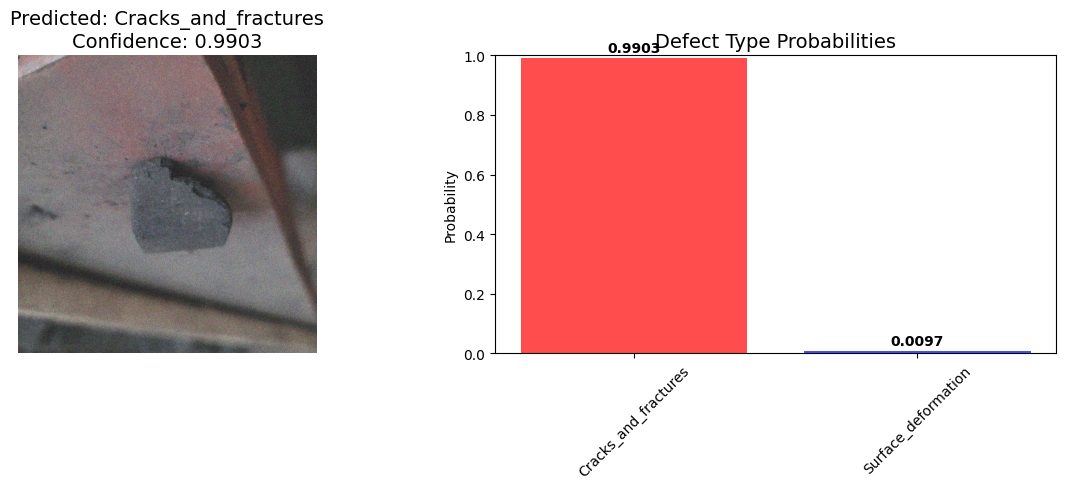


DEFECT CLASSIFICATION RESULTS:
Predicted Defect Type: Cracks_and_fractures
Confidence: 0.9903

All Probabilities:
  Cracks_and_fractures: 0.9903
  Surface_deformation: 0.0097


{'predicted_class': 'Cracks_and_fractures',
 'confidence': 0.9903292655944824,
 'all_probabilities': {'Cracks_and_fractures': 0.9903292655944824,
  'Surface_deformation': 0.00967075489461422}}

In [14]:
# Example usage:
test_single_image(r"E:\AI Deep learning\coal_project\project2_largdata_coal\coal_defect_classification\val\Cracks_and_fractures\20251012_094807_aug_10.jpg")

Testing defect classification with image: E:\AI Deep learning\coal_project\project2_largdata_coal\coal_defect_classification\val\Cracks_and_fractures\20251012_095550_aug_6.jpg


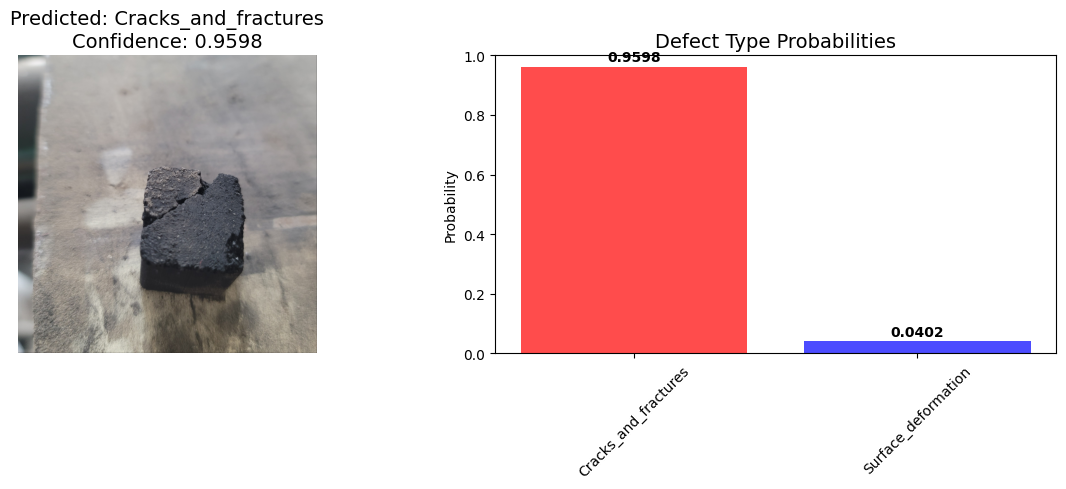


DEFECT CLASSIFICATION RESULTS:
Predicted Defect Type: Cracks_and_fractures
Confidence: 0.9598

All Probabilities:
  Cracks_and_fractures: 0.9598
  Surface_deformation: 0.0402


{'predicted_class': 'Cracks_and_fractures',
 'confidence': 0.9598053693771362,
 'all_probabilities': {'Cracks_and_fractures': 0.9598053693771362,
  'Surface_deformation': 0.04019459709525108}}

In [15]:
# Example usage:
test_single_image(r"E:\AI Deep learning\coal_project\project2_largdata_coal\coal_defect_classification\val\Cracks_and_fractures\20251012_095550_aug_6.jpg")


Testing defect classification with image: E:\AI Deep learning\coal_project\project2_largdata_coal\coal_defect_classification\val\Surface_deformation\20251012_095018.jpg


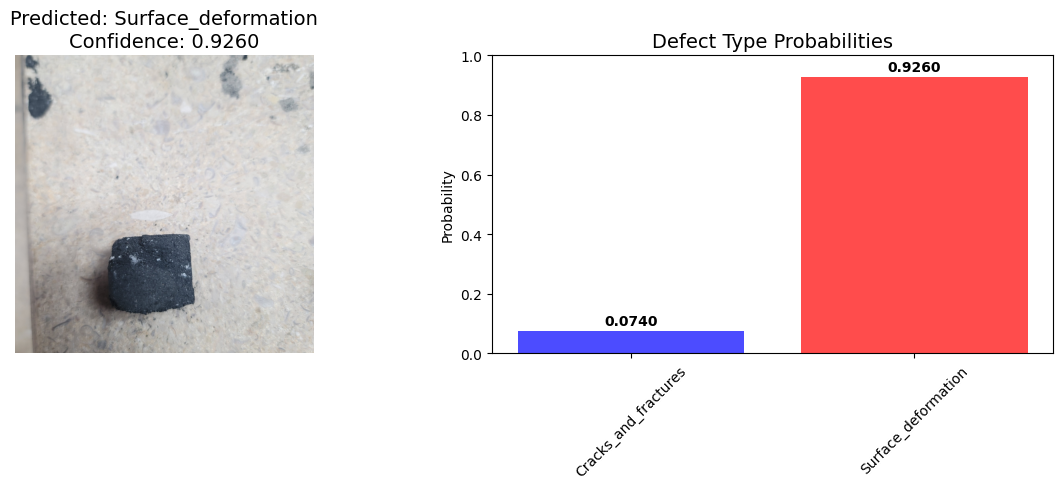


DEFECT CLASSIFICATION RESULTS:
Predicted Defect Type: Surface_deformation
Confidence: 0.9260

All Probabilities:
  Cracks_and_fractures: 0.0740
  Surface_deformation: 0.9260


{'predicted_class': 'Surface_deformation',
 'confidence': 0.9260016083717346,
 'all_probabilities': {'Cracks_and_fractures': 0.0739983543753624,
  'Surface_deformation': 0.9260016083717346}}

In [16]:
# Example usage:
test_single_image(r"E:\AI Deep learning\coal_project\project2_largdata_coal\coal_defect_classification\val\Surface_deformation\20251012_095018.jpg")
